### Importing necessary libraries

In [63]:
import math
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Creating a GPU device if available

In [64]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


### CNN Hyperparameters

In [65]:
image_base_size = 256
num_epochs = 10
batch_size = 10
learning_rate = 0.001

### Creating the dataset and loading in the monkeys

In [66]:


composed = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([image_base_size, image_base_size])  # Square images idea for CNN

])

class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        # Read monkey image from directory name
        monkey = read_image(monkey_path)

        # Get monkey label from filename
        label = int(monkey_filename[1:2])  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms:
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        # This will allow len()
        return self.number_samples
    
    def get_label_map(self):
        print({i.strip():j.strip() for i, j in zip(self.img_labels.iloc[:, 0], self.img_labels.iloc[:, 2])})

    def get_label_map2(self):
        print({i.strip():j for i, j in zip(self.img_labels.iloc[:, 0], range(0, 10))})



# train_data = MonkeyDataset()
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)
validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

label2name = training_data.get_label_map()
label2num = training_data.get_label_map2()
pprint(label2name, label2num)

{'n0': 'mantled_howler', 'n1': 'patas_monkey', 'n2': 'bald_uakari', 'n3': 'japanese_macaque', 'n4': 'pygmy_marmoset', 'n5': 'white_headed_capuchin', 'n6': 'silvery_marmoset', 'n7': 'common_squirrel_monkey', 'n8': 'black_headed_night_monkey', 'n9': 'nilgiri_langur'}
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
None


### Testing dataloaders and showing example monkey

tensor([[[0.6083, 0.6188, 0.5767,  ..., 0.3102, 0.3238, 0.3367],
         [0.5987, 0.6569, 0.7268,  ..., 0.4018, 0.3703, 0.3105],
         [0.7261, 0.7237, 0.6746,  ..., 0.4077, 0.3619, 0.3008],
         ...,
         [0.4037, 0.4071, 0.4166,  ..., 0.5987, 0.5890, 0.6119],
         [0.2548, 0.2526, 0.2692,  ..., 0.6049, 0.6330, 0.6598],
         [0.2335, 0.2321, 0.2222,  ..., 0.6151, 0.6245, 0.6579]],

        [[0.6282, 0.6345, 0.5925,  ..., 0.4020, 0.3949, 0.3979],
         [0.6255, 0.7163, 0.7801,  ..., 0.5165, 0.4715, 0.3790],
         [0.8022, 0.8053, 0.7608,  ..., 0.5338, 0.4901, 0.4020],
         ...,
         [0.5632, 0.5669, 0.5990,  ..., 0.6413, 0.6259, 0.6429],
         [0.3871, 0.3971, 0.4143,  ..., 0.6339, 0.6686, 0.6954],
         [0.3747, 0.3772, 0.3673,  ..., 0.6464, 0.6567, 0.6931]],

        [[0.5374, 0.5297, 0.4522,  ..., 0.2227, 0.2388, 0.2668],
         [0.3995, 0.4605, 0.5153,  ..., 0.2778, 0.2265, 0.2010],
         [0.5541, 0.5414, 0.4365,  ..., 0.2667, 0.2221, 0.

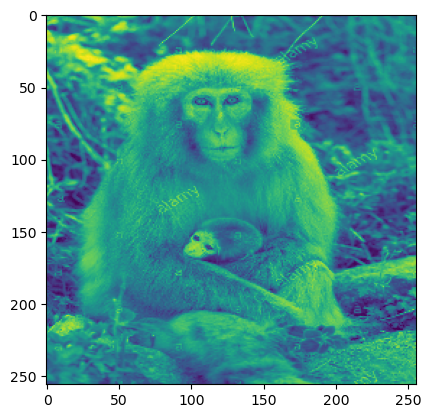

In [67]:
# dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# iterating through the dataloader
train_features, train_labels = next(iter(train_dataloader))
print(train_features[0], train_labels)
print(train_features.size())  # batch size, channel count, image size
plt.imshow(train_features[0][0])
plt.show()

### Defining the CNN class

In [68]:
class CNN(nn.Module):
    def __init__(self) -> None:
        # torch.utils.data.Dataset doesn’t define its own __init__ so by calling super().__init__() you are not performing any meaningful actions. In comparison, calling super().__init__() when subclassing torch.nn.Module is required to initialize the internal data structures for storing buffers, modules, etc.
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # End up with size of 30 for the regular neural network
        self.full_con1 = nn.Linear(8*8*24, 1000)
        self.full_con2 = nn.Linear(1000, 100)
        self.full_con3 = nn.Linear(100, 10)
    
    def forward(self, x):
        # This whole first part is classification learning
        s = self.pool(F.leaky_relu(self.conv1(x)))  # Function takes in a tensor as input
        s = self.pool(F.leaky_relu(self.conv2(s)))
        s = self.pool(F.leaky_relu(self.conv3(s)))

        # Output channels * image width * image height
        s = torch.reshape(s, [-1, 8*8*24])
        s.size()
        # s = 

        # This whole second part is feature learning
        s = F.leaky_relu(self.full_con1(s))
        s = F.leaky_relu(self.full_con2(s))
        s = self.full_con3(s)

        return s

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (full_con1): Linear(in_features=1536, out_features=1000, bias=True)
  (full_con2): Linear(in_features=1000, out_features=100, bias=True)
  (full_con3): Linear(in_features=100, out_features=10, bias=True)
)


### Optimization code

In [69]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for iteration, (monkey, label) in enumerate(train_dataloader):
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label)

        # Forward pass
        # Pass on torch.Size([64, 3, 256, 256])
        pred = model.forward(monkey)
        # pred2 = model(monkey)
        # print(pred == pred2)

        # Clearing out optimizer grad
        optimizer.zero_grad()

        # Calculate loss
        # Target is a value between 0 and C
        # print(label)
        loss = loss_fn(pred, label)

        # Backward pass
        loss.backward()

        # Optimize (step)
        optimizer.step()

        print(f"Epoch:\t{epoch}\tIteration:\t{iteration}\tLoss:\t{loss}")
        

Epoch:	0	Iteration:	0	Loss:	2.2936573028564453
Epoch:	0	Iteration:	1	Loss:	2.2780051231384277
Epoch:	0	Iteration:	2	Loss:	2.2987961769104004
Epoch:	0	Iteration:	3	Loss:	2.297229766845703
Epoch:	0	Iteration:	4	Loss:	2.258280038833618
Epoch:	0	Iteration:	5	Loss:	2.398146152496338
Epoch:	0	Iteration:	6	Loss:	2.34977650642395
Epoch:	0	Iteration:	7	Loss:	2.3869738578796387
Epoch:	0	Iteration:	8	Loss:	2.283428907394409
Epoch:	0	Iteration:	9	Loss:	2.3551361560821533
Epoch:	0	Iteration:	10	Loss:	2.3418173789978027
Epoch:	0	Iteration:	11	Loss:	2.3095288276672363
Epoch:	0	Iteration:	12	Loss:	2.310296058654785
Epoch:	0	Iteration:	13	Loss:	2.2992606163024902
Epoch:	0	Iteration:	14	Loss:	2.2955148220062256
Epoch:	0	Iteration:	15	Loss:	2.259981393814087
Epoch:	0	Iteration:	16	Loss:	2.301292896270752
Epoch:	0	Iteration:	17	Loss:	2.356562614440918
Epoch:	0	Iteration:	18	Loss:	2.302032709121704
Epoch:	0	Iteration:	19	Loss:	2.3006930351257324
Epoch:	0	Iteration:	20	Loss:	2.30656361579895
Epoch:	0	Iterat

### Evaluating model accuracy with actual dataset

In [98]:
with torch.no_grad():
    tot = 0
    right = 0
    for monkey, label in test_dataloader:  # Rename this to validation_dataloader later
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label) # Actual monkey, actual label

        guess = model(monkey)
        maxes, indicies = torch.max(guess, 1)
        
        right += sum(indicies == label)
        tot += indicies.shape[0]
        # print(indicies, label, torch.sum())

        # print(torch.sum)

print(f"Final Acc: {right/tot}")


Final Acc: 0.5808823704719543


### Random testing scrips down here

In [70]:

e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]

tf = train_features
# print(tf, type(tf), tf.size())

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=3, stride=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
# self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
# self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
# End up with size of 30 for the regular neural network
full_con1 = nn.Linear(8*8*24, 100)
full_con2 = nn.Linear(100, 50)
full_con3 = nn.Linear(50, 10)

# This whole first part is classification learning
s = pool(F.leaky_relu(conv1(tf)))  # Function takes in a tensor as input
print(type(s), s.size())
s = pool(F.leaky_relu(conv2(s)))
print(type(s), s.size())
s = pool(F.leaky_relu(conv3(s)))
print(type(s), s.size())

# Output channels * image width * image height
# s.view(-1, 30*30*24).size()
s = torch.reshape(s, [-1, 8*8*24])
s.size()
# s = 

# This whole second part is feature learning
s = F.leaky_relu(full_con1(s))
print(type(s), s.size())
s = F.leaky_relu(full_con2(s))
print(type(s), s.size())
s = full_con3(s)
print(type(s), s.size())


print(model.base.parameters())
print(model.classifier.parameters())
for p in model.parameters():
    print(p)

<class 'torch.Tensor'> torch.Size([10, 6, 84, 84])
<class 'torch.Tensor'> torch.Size([10, 12, 27, 27])
<class 'torch.Tensor'> torch.Size([10, 24, 8, 8])
<class 'torch.Tensor'> torch.Size([10, 100])
<class 'torch.Tensor'> torch.Size([10, 50])
<class 'torch.Tensor'> torch.Size([10, 10])


AttributeError: 'CNN' object has no attribute 'base'